# First, let's import a pre-trained model and prepare the data

In [1]:
import torch

In [2]:
trained_model_path = '../saved_models/SM0-0.pth.tar'

In [204]:
trained_model = torch.load(trained_model_path,map_location=torch.device('cpu'))

In [205]:
from SwinAgeMapper import SwinAgeMapper

In [206]:
model = SwinAgeMapper(
                    img_size = (160,192,160),
                    in_channels = 1,
                    depths = (2, 2, 2, 2),
                    num_heads = (3, 6, 12, 24),
                    feature_size = 24,
                    drop_rate = 0.0,
                    attn_drop_rate = 0.0,
                    dropout_path_rate = 0.0,
                    use_checkpoint = True,
                    spatial_dims = 3,
                    downsample = "merging",
                    fully_connected_activation = "relu",
                    resolution='1mm',
                    )

In [207]:
model.load_state_dict(trained_model)

<All keys matched successfully>

In [208]:
model.eval()

SwinAgeMapper(
  (Upsample): Identity()
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear

In [209]:
for key in model.state_dict().keys():
    print(key, '\n\t', model.state_dict()[key].shape)

swinViT.patch_embed.proj.weight 
	 torch.Size([24, 1, 2, 2, 2])
swinViT.patch_embed.proj.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm1.weight 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm1.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table 
	 torch.Size([2197, 3])
swinViT.layers1.0.blocks.0.attn.relative_position_index 
	 torch.Size([343, 343])
swinViT.layers1.0.blocks.0.attn.qkv.weight 
	 torch.Size([72, 24])
swinViT.layers1.0.blocks.0.attn.qkv.bias 
	 torch.Size([72])
swinViT.layers1.0.blocks.0.attn.proj.weight 
	 torch.Size([24, 24])
swinViT.layers1.0.blocks.0.attn.proj.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm2.weight 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm2.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.mlp.linear1.weight 
	 torch.Size([96, 24])
swinViT.layers1.0.blocks.0.mlp.linear1.bias 
	 torch.Size([96])
swinViT.layers1.0.blocks.0.mlp.linear2.weight 
	 torch.Size([24, 96])
swinViT.layers1.0.bl

In [3]:
import nibabel as nib
import numpy as np
import pandas as pd

In [4]:
# X_path = '../../multi-age-mapper/additional_data_examples/24237795/T1_brain_to_MNI.nii.gz'
# X2_path = '../../multi-age-mapper/additional_data_examples/24806531/T1_brain_to_MNI.nii.gz'
scaling_values = '../../../SwinAgeMapper/datasets/scaling_values_simple.csv'
X_path = '24237795'
# X2_path = '24806531'
# X_path = '24806531'

In [5]:
def processs_inputs(modality_flag='T1_nonlinear',
                    subject_path='24237795'
                   ):
    
    scaling_values_simple = pd.read_csv(scaling_values, index_col=0)
    scale_factor = scaling_values_simple.loc[modality_flag].scale_factor
    # resolution = scaling_values_simple.loc[list(modality_flag)].resolution.to_list()
    
    X_path = '../../multi-age-mapper/additional_data_examples/' + subject_path + '/T1_brain_to_MNI.nii.gz'
    X_volume = np.array(nib.load(X_path).dataobj)
    
    crop_values = [10, 170, 12, 204, 0, 160]
    
    X_volume = X_volume[crop_values[0]:crop_values[1],
                        crop_values[2]:crop_values[3], 
                        crop_values[4]:crop_values[5]]
    
    X_volume = X_volume / X_volume.mean()
    
    X_volume = X_volume / scale_factor
    X_volume = torch.from_numpy(X_volume)
    
    return X_volume

In [6]:
X = processs_inputs(subject_path = X_path)

In [7]:
X.shape

torch.Size([160, 192, 160])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(-0.5, 191.5, 159.5, -0.5)

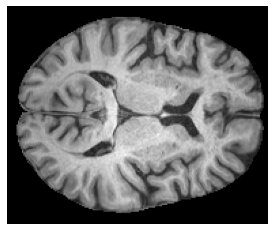

In [9]:
plt.imshow(X[:,:,80], cmap='gray')
plt.grid()
plt.axis('off')

In [10]:
from scipy import ndimage

(-0.5, 159.5, 191.5, -0.5)

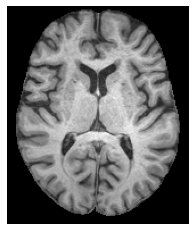

In [11]:
plt.imshow(ndimage.rotate(X[:,:,80], 90), cmap='gray')
plt.grid()
plt.axis('off')

In [12]:
Xviz = X.numpy().copy()
X = torch.unsqueeze(torch.unsqueeze(X, dim=0), dim=0)
X.shape

torch.Size([1, 1, 160, 192, 160])

In [220]:
model(X)

tensor([[76.6087]], grad_fn=<AddmmBackward0>)

In [221]:
y = model(X)

In [222]:
# del model
# del X
# del y

# Let's try to get some attention

In [223]:
head_fusion='max'
discard_ratio = 0.9

def rollout(attentions, discard_ratio, head_fusion):
    # result = torch.eye(attentions[0].size(-1))
    
    results = []
    
    with torch.no_grad():
        for attention in attentions:
            results.append(attention)
            
            print(attention.shape)
            
#             if head_fusion == "mean":
#                 attention_heads_fused = attention.mean(axis=1)
#             elif head_fusion == "max":
#                 attention_heads_fused = attention.max(axis=1)[0]
#             elif head_fusion == "min":
#                 attention_heads_fused = attention.min(axis=1)[0]
#             else:
#                 raise "Attention head fusion type Not supported"

#             # Drop the lowest attentions, but
#             # don't drop the class token
#             flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
#             _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
#             indices = indices[indices != 0]
#             flat[0, indices] = 0

#             I = torch.eye(attention_heads_fused.size(-1))
#             a = (attention_heads_fused + 1.0*I)/2
#             a = a / a.sum(dim=-1)

#             result = torch.matmul(a, result)
    
#     # Look at the total attention between the class token,
#     # and the image patches
#     mask = result[0, 0 , 1 :]
#     # In case of 224x224 image, this brings us from 196 to 14
#     width = int(mask.size(-1)**0.5)
#     mask = mask.reshape(width, width).numpy()
#     mask = mask / np.max(mask)
#     return mask   

    return results

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='softmax', head_fusion="mean", ###########  softmax, attn_drop
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():

            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [224]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask = attention_rollout(X)
# name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

Doing Attention Rollout


None of the inputs have requires_grad=True. Gradients will be None


torch.Size([2016, 3, 343, 343])
torch.Size([2016, 3, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([8, 24, 343, 343])
torch.Size([8, 24, 343, 343])


In [225]:
len(mask)

8

In [226]:
from SwinAgeMapper import window_reverse
from math import ceil, floor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from torch.nn import Upsample, ConstantPad3d

In [229]:
def GetAttentionActivation(mask, idx=0):

    msk = mask[idx]
    mskQMean = msk.mean(axis=2) # mean across the querry axis
    mskQMean = mskQMean.permute(1,0,2)
    window_size = round(mskQMean.size(-1)**(1/3))

    mskQMean = mskQMean.view(mskQMean.shape[0], mskQMean.shape[1], window_size, window_size, window_size)

    n_windows_x = ceil(160/(7*2))
    n_windows_y = ceil(192/(7*2))
    n_windows_z = ceil(160/(7*2))
    
    d, h, w = 80, 96, 80

    if idx / 2 >= 1:
        idxPower = floor(idx / 2)
        n_windows_x = ceil(n_windows_x/2**idxPower)
        n_windows_y = ceil(n_windows_y/2**idxPower)
        n_windows_z = ceil(n_windows_z/2**idxPower)
        
        d, h, w = int(d / 2**idxPower), int(h / 2**idxPower), int(w / 2**idxPower)

        
    print('mskQMean', mskQMean.shape)

    out = window_reverse(mskQMean, (7,7,7), 
                         dims=(mskQMean.shape[0], n_windows_x*7, n_windows_y*7, n_windows_z*7)).squeeze()
    
    print('out_window_reverse', out.shape)

    
    if idx % 2 == 1:
        out = torch.roll(out, shifts=(3,3,3), dims=(1, 2, 3))
        
    print('out_rol', out.shape)
           
    out = out[:, :d, :h, :w].contiguous()
    
    print('out_crop', out.shape)

    scale_factor = 2**(floor(idx / 2)+1)
    upsample = Upsample(scale_factor=scale_factor)

    outUp = upsample(torch.unsqueeze(out, 1)).squeeze()
    
    print('outUp', outUp.shape)

    outUpCropMean = torch.mean(outUp, axis=0)
    outUpCropMax = torch.max(outUp, axis=0)[0]
    
    return outUp, outUpCropMean, outUpCropMax

def GetAllAttentionActivations(mask):
    
    outUpS, outUpCropMeanS, outUpCropMaxS = [], [], []
    
    for idx in range(len(mask)):
        print('Processing Mask {}/{}'.format(idx, len(mask)-1))
        outUp, outUpCropMean, outUpCropMax = GetAttentionActivation(mask, idx=idx)
        outUpS.append(outUp)
        outUpCropMeanS.append(outUpCropMean)
        outUpCropMaxS.append(outUpCropMax)
        
    return outUpS, outUpCropMeanS, outUpCropMaxS

In [230]:
outUpS, outUpCropMeanS, outUpCropMaxS = GetAllAttentionActivations(mask)

Processing Mask 0/7
mskQMean torch.Size([3, 2016, 7, 7, 7])
out_window_reverse torch.Size([3, 84, 98, 84])
out_rol torch.Size([3, 84, 98, 84])
out_crop torch.Size([3, 80, 96, 80])
outUp torch.Size([3, 160, 192, 160])
Processing Mask 1/7
mskQMean torch.Size([3, 2016, 7, 7, 7])
out_window_reverse torch.Size([3, 84, 98, 84])
out_rol torch.Size([3, 84, 98, 84])
out_crop torch.Size([3, 80, 96, 80])
outUp torch.Size([3, 160, 192, 160])
Processing Mask 2/7
mskQMean torch.Size([6, 252, 7, 7, 7])
out_window_reverse torch.Size([6, 42, 49, 42])
out_rol torch.Size([6, 42, 49, 42])
out_crop torch.Size([6, 40, 48, 40])
outUp torch.Size([6, 160, 192, 160])
Processing Mask 3/7
mskQMean torch.Size([6, 252, 7, 7, 7])
out_window_reverse torch.Size([6, 42, 49, 42])
out_rol torch.Size([6, 42, 49, 42])
out_crop torch.Size([6, 40, 48, 40])
outUp torch.Size([6, 160, 192, 160])
Processing Mask 4/7
mskQMean torch.Size([12, 36, 7, 7, 7])
out_window_reverse torch.Size([12, 21, 28, 21])
out_rol torch.Size([12, 21,

In [81]:
outUpCropMeanS[0].shape

torch.Size([160, 192, 160])

In [82]:
def plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx, cmap='viridis'):
    
    # CMAP ideas: viridis(default), inferno, bwr

    outUp = outUpS[idx]
    outUpCropMean = outUpCropMeanS[idx]
    outUpCropMax = outUpCropMaxS[idx]

    imgs = outUp.shape[0]
    # vmin = outUp.numpy().min()
    # vmax = outUp.numpy().max()
    fig, axs = plt.subplots(3, imgs, figsize=(imgs*5, 3*5))
    axs = axs.flatten()
    for i in range(imgs*3):
        if i < imgs:
            im = axs[i].imshow(ndimage.rotate(outUp[i,:,:,80], 90), cmap=cmap)
        elif i < 2*imgs:
            im = axs[i].imshow(ndimage.rotate(outUp[i-2*imgs,:,80,:], 90), cmap=cmap)
        else:
            im = axs[i].imshow(ndimage.rotate(outUp[i-3*imgs,80,:,:], 90), cmap=cmap)

        axs[i].grid()
        axs[i].axis('off');

        fig.colorbar(im, ax=axs[i])

    fig.tight_layout()
    st = fig.suptitle("Plots Across Multi-Heads", fontsize="xx-large")
    fig.subplots_adjust(top=0.95)



    fig, axs = plt.subplots(2,3, figsize=(15, 10))
    axs = axs.flatten()
    im = axs[0].imshow(ndimage.rotate(outUpCropMean[:,:,80], 90), cmap=cmap)
    axs[0].grid()
    axs[0].axis('off');
    fig.colorbar(im, ax=axs[0])
    im = axs[1].imshow(ndimage.rotate(outUpCropMean[:,80,:], 90), cmap=cmap)
    axs[1].grid()
    axs[1].axis('off');
    fig.colorbar(im, ax=axs[1])
    im = axs[2].imshow(ndimage.rotate(outUpCropMean[80,:,:], 90), cmap=cmap)
    axs[2].grid()
    axs[2].axis('off');
    fig.colorbar(im, ax=axs[2])
    im = axs[3].imshow(ndimage.rotate(outUpCropMax[:,:,80], 90), cmap=cmap)
    axs[3].grid()
    axs[3].axis('off');
    fig.colorbar(im, ax=axs[3])
    im = axs[4].imshow(ndimage.rotate(outUpCropMax[:,80,:], 90), cmap=cmap)
    axs[4].grid()
    axs[4].axis('off');
    fig.colorbar(im, ax=axs[4])
    im = axs[5].imshow(ndimage.rotate(outUpCropMax[80,:,:], 90), cmap=cmap)
    axs[5].grid()
    axs[5].axis('off');
    fig.colorbar(im, ax=axs[5])
    fig.tight_layout()

    st = fig.suptitle("Mean and Max Across Multi-Heads", fontsize="xx-large")
    fig.subplots_adjust(top=0.95)

In [83]:
outUpS_npy, outUpCropMeanS_npy, outUpCropMaxS_npy = [], [], []

for file in outUpS:
    file = file.numpy()
    outUpS_npy.append(file)
    
for file in outUpCropMeanS:
    file = file.numpy()
    outUpCropMeanS_npy.append(file)
    
for file in outUpCropMaxS:
    file = file.numpy()
    outUpCropMaxS_npy.append(file)

In [84]:
type(outUpS_npy[0])

numpy.ndarray

In [85]:
np.save('outUpS.npy',         np.array(outUpS_npy,         dtype=object), allow_pickle=True)
np.save('outUpCropMeanS.npy', np.array(outUpCropMeanS_npy, dtype=object), allow_pickle=True)
np.save('outUpCropMaxS.npy',  np.array(outUpCropMaxS_npy,  dtype=object), allow_pickle=True)

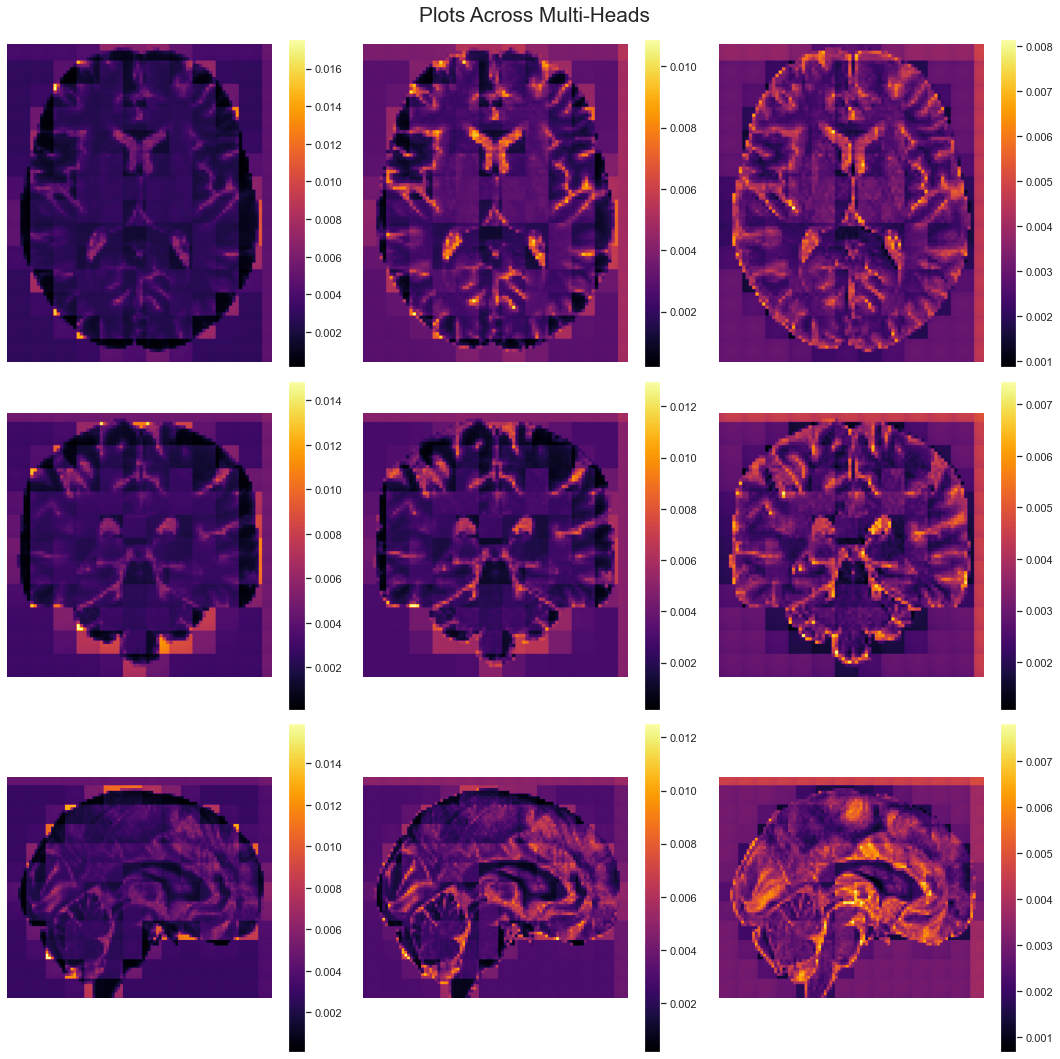

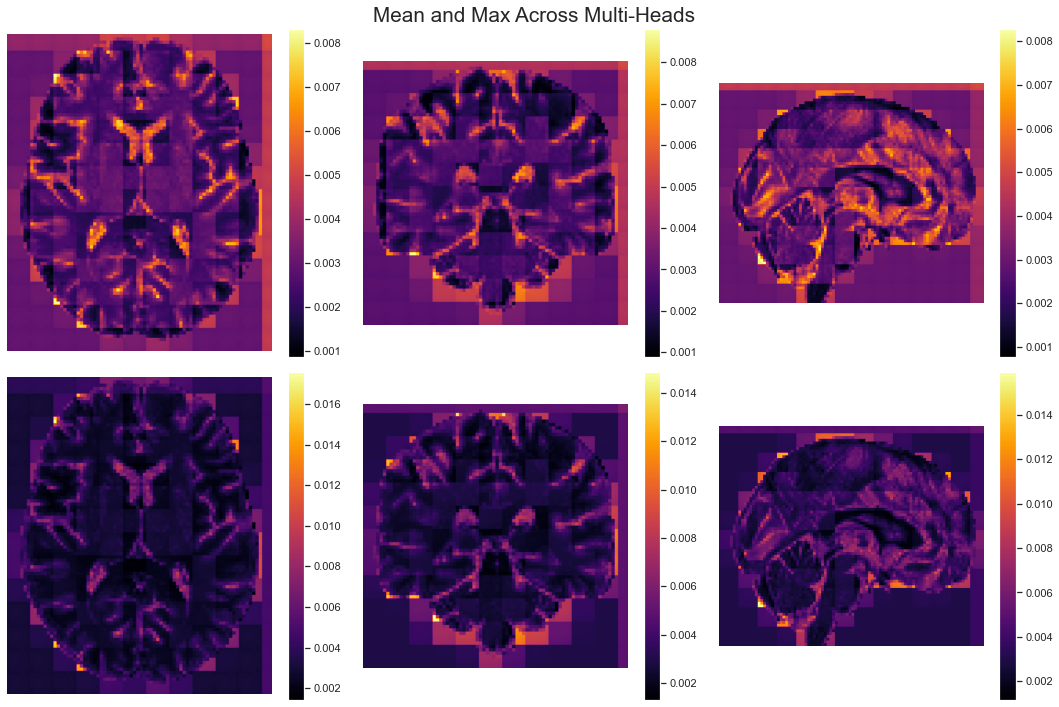

In [86]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=0, cmap='inferno')

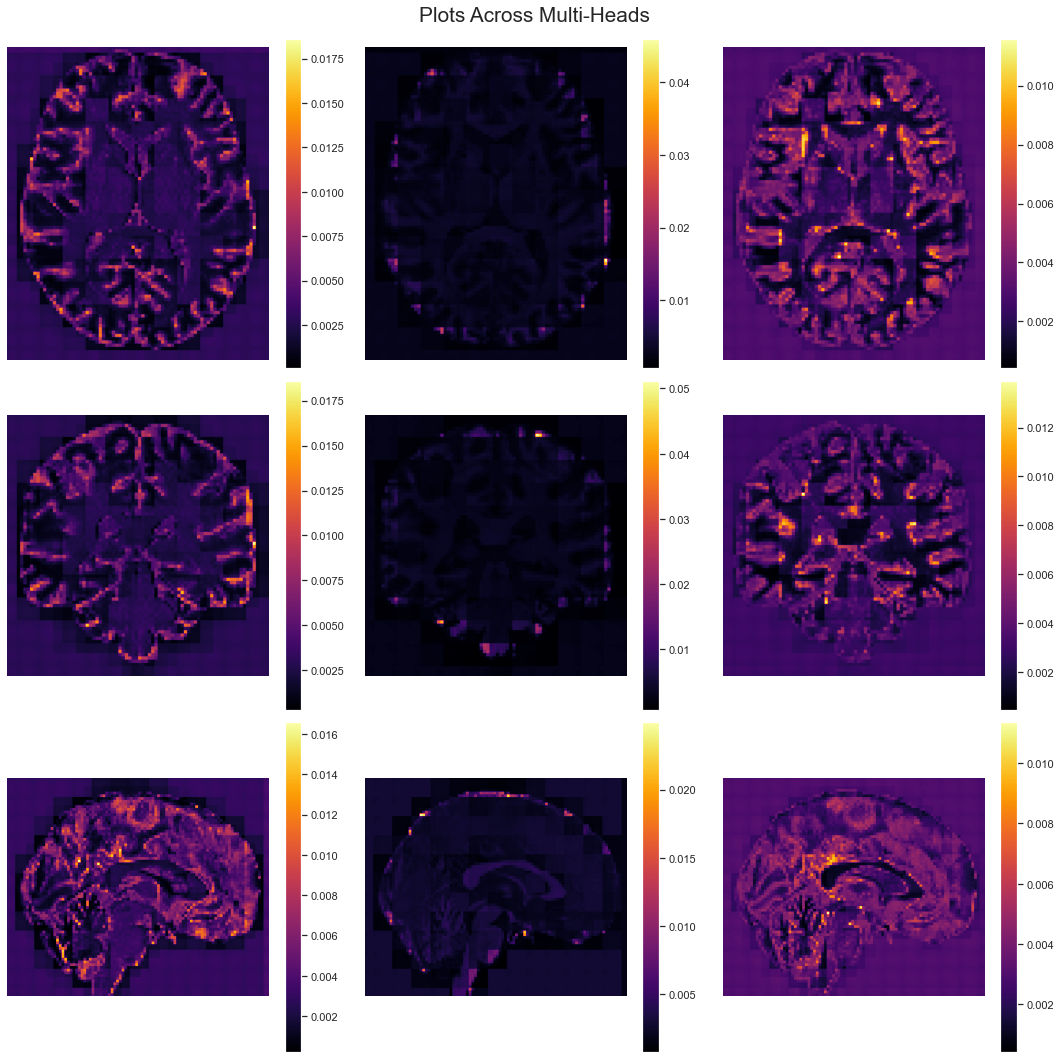

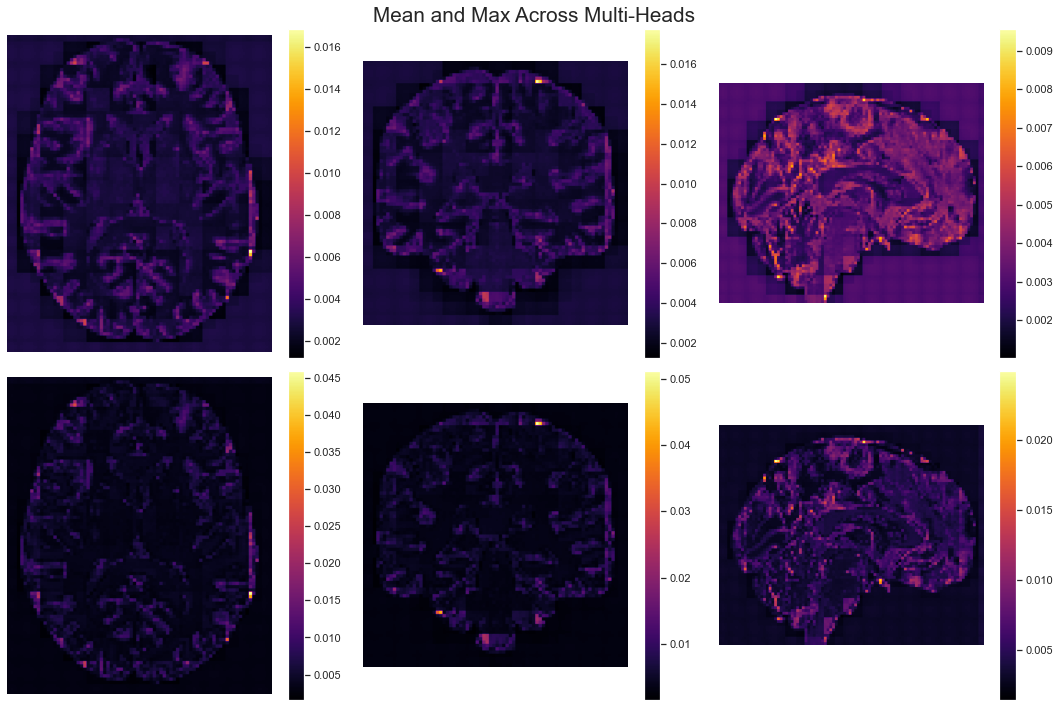

In [87]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=1, cmap='inferno')

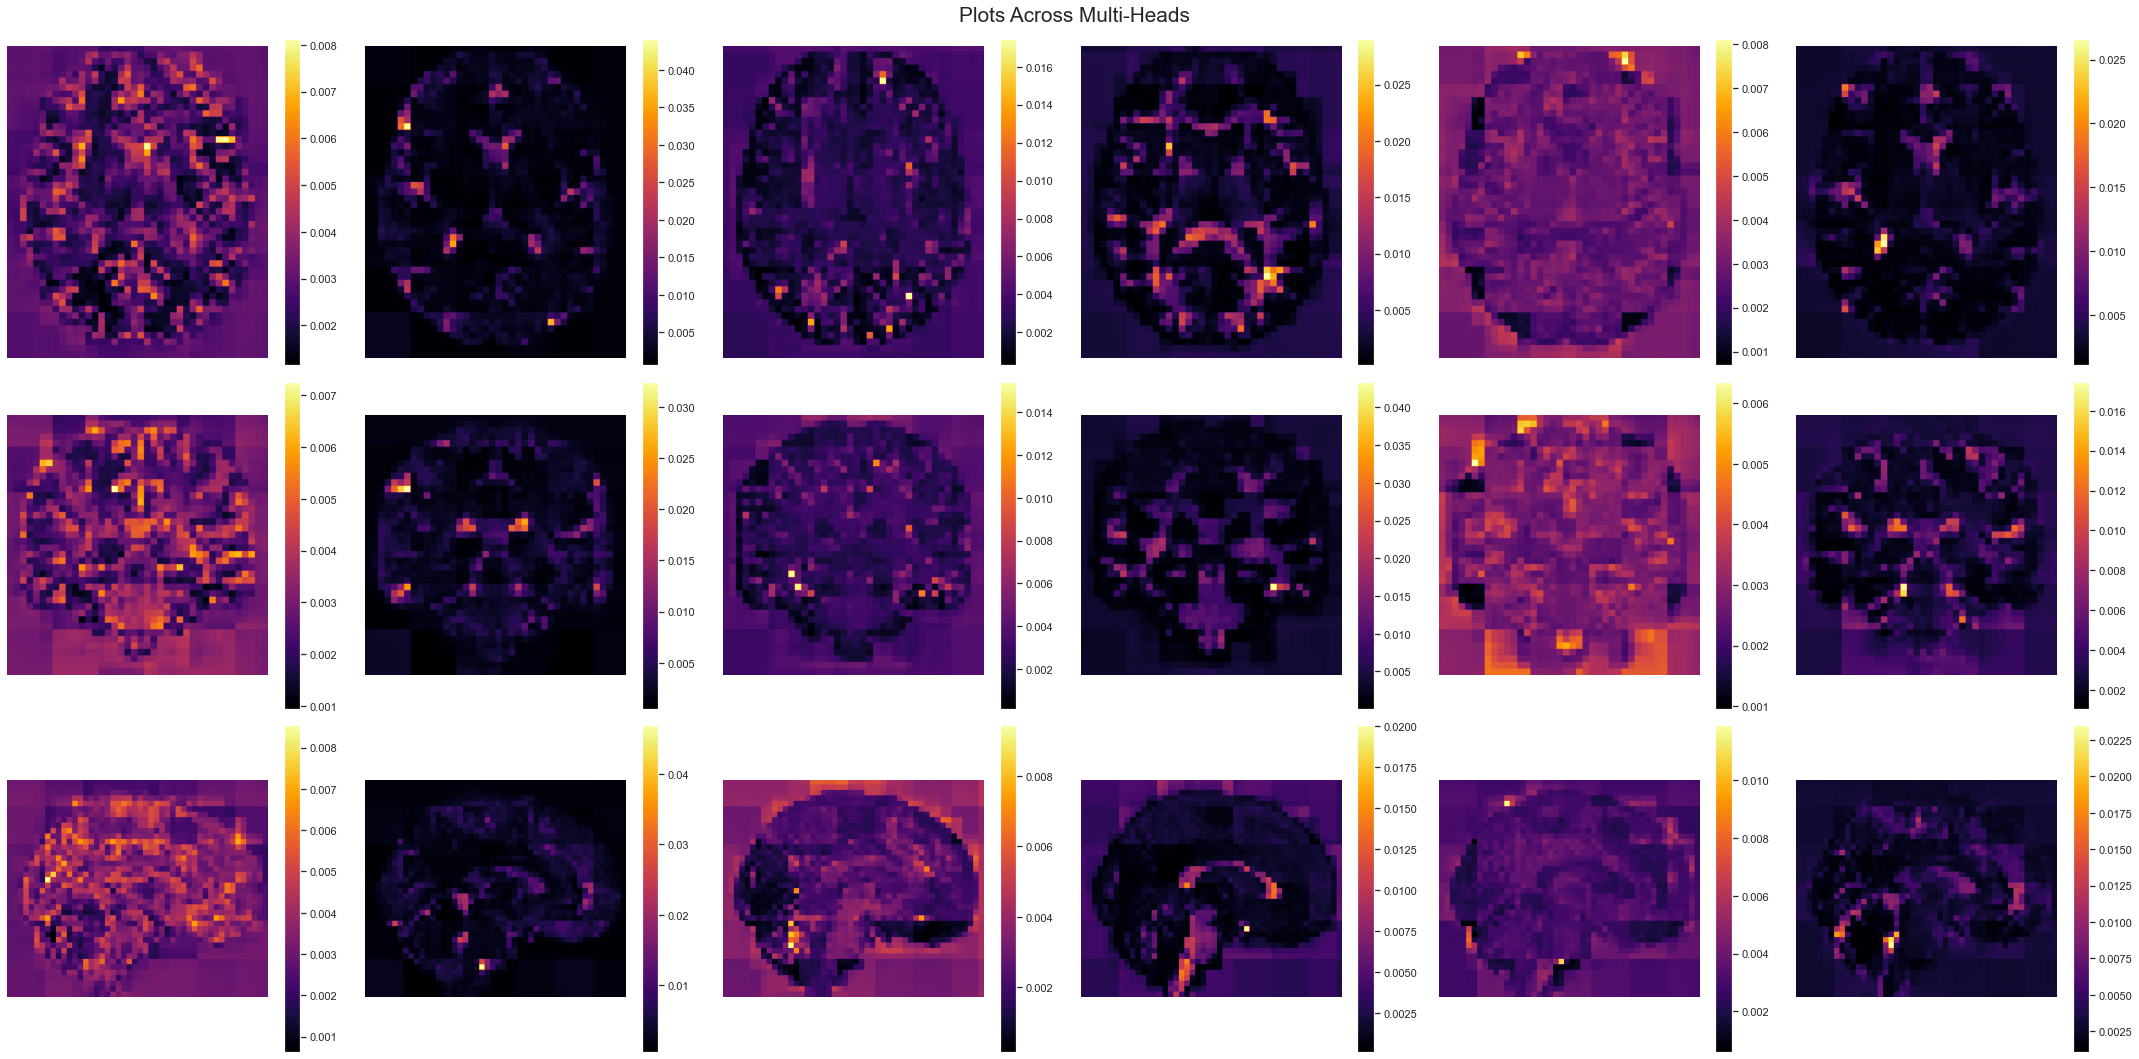

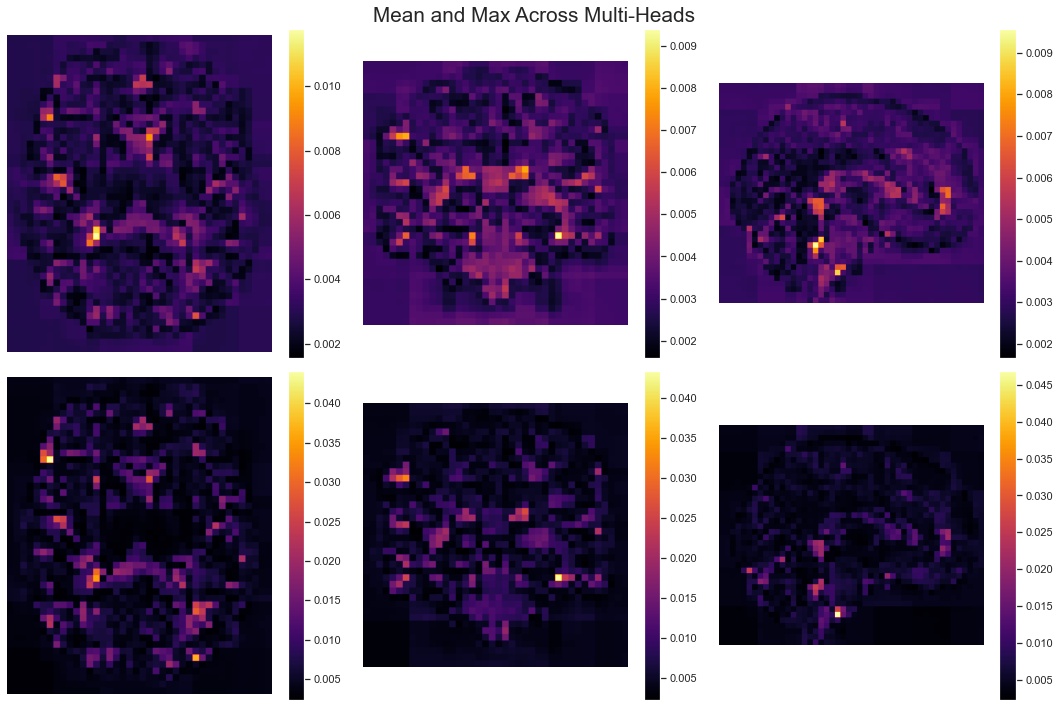

In [88]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=2, cmap='inferno')

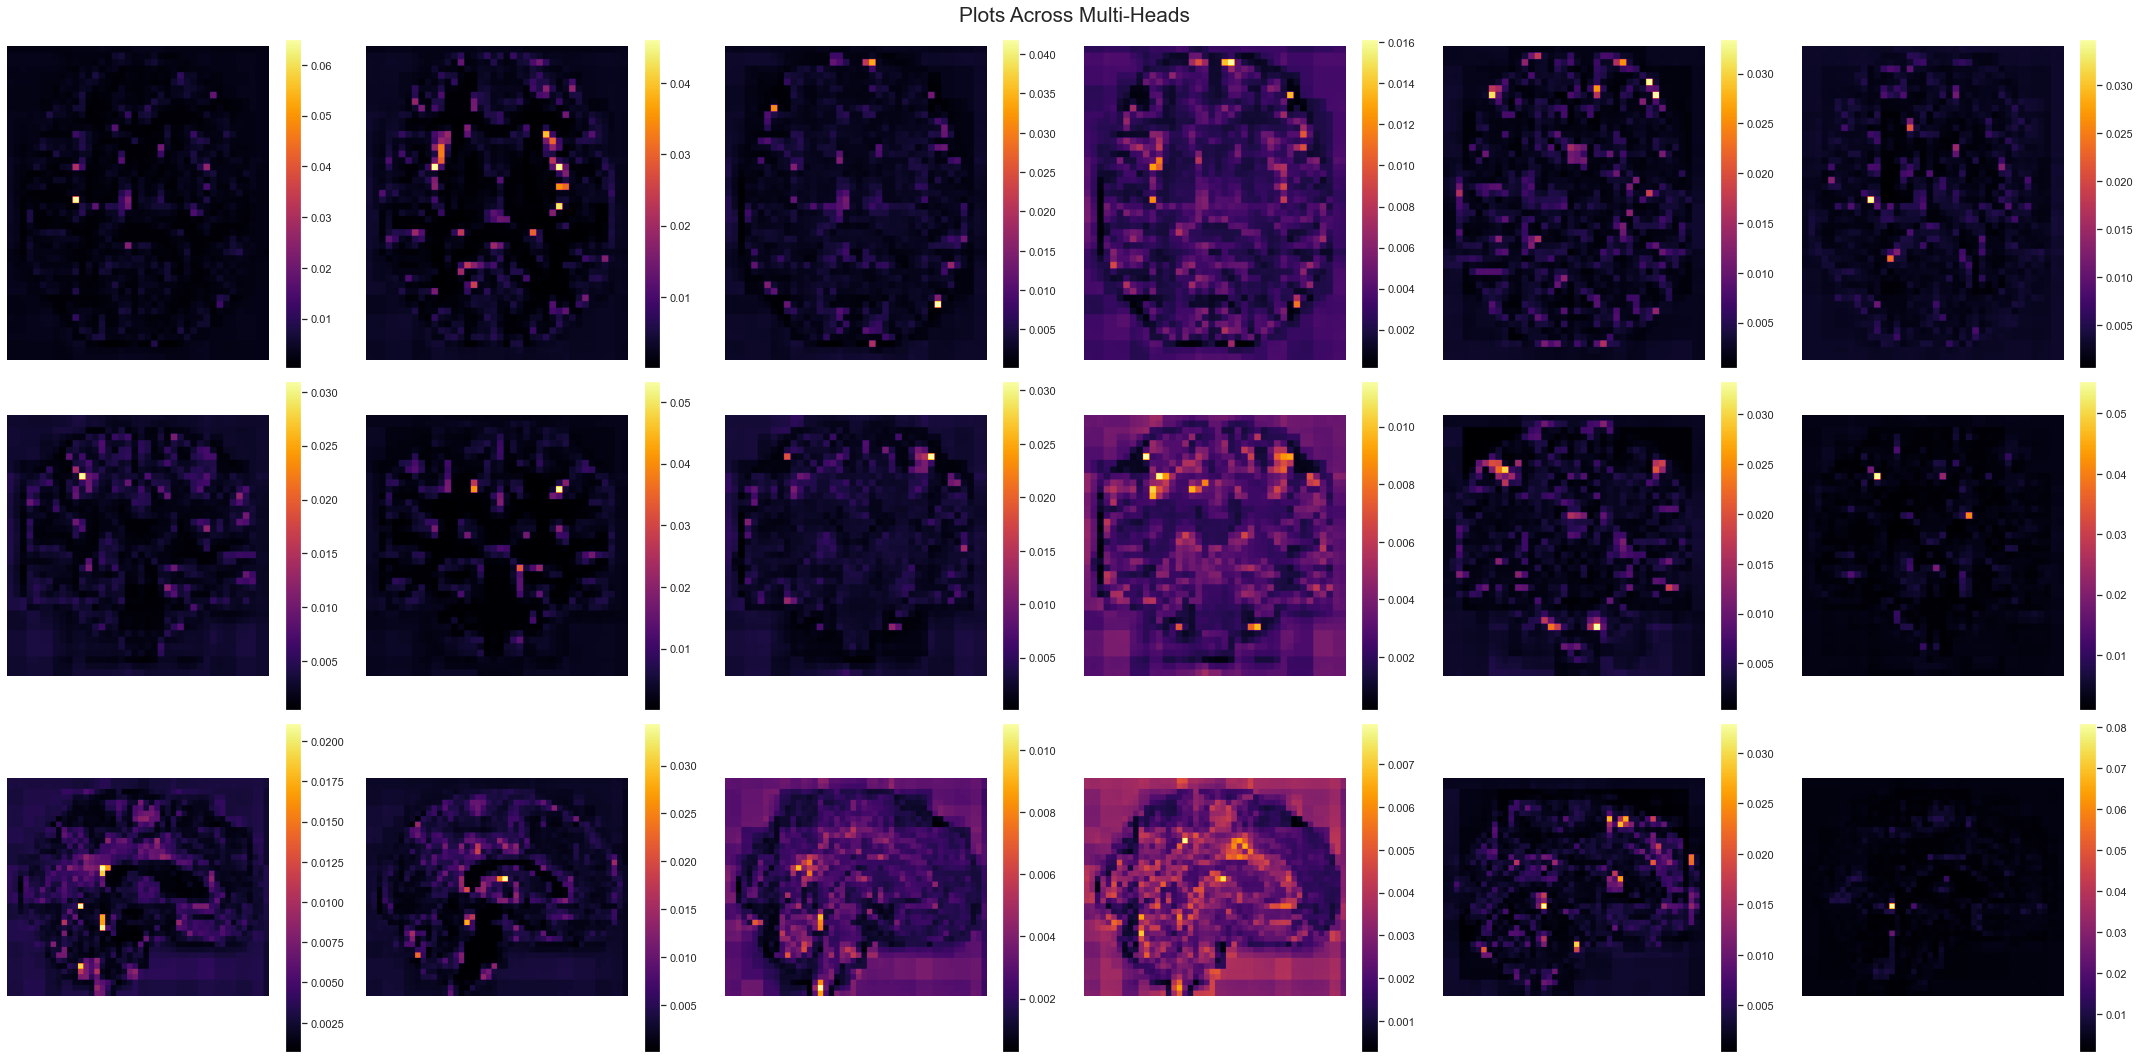

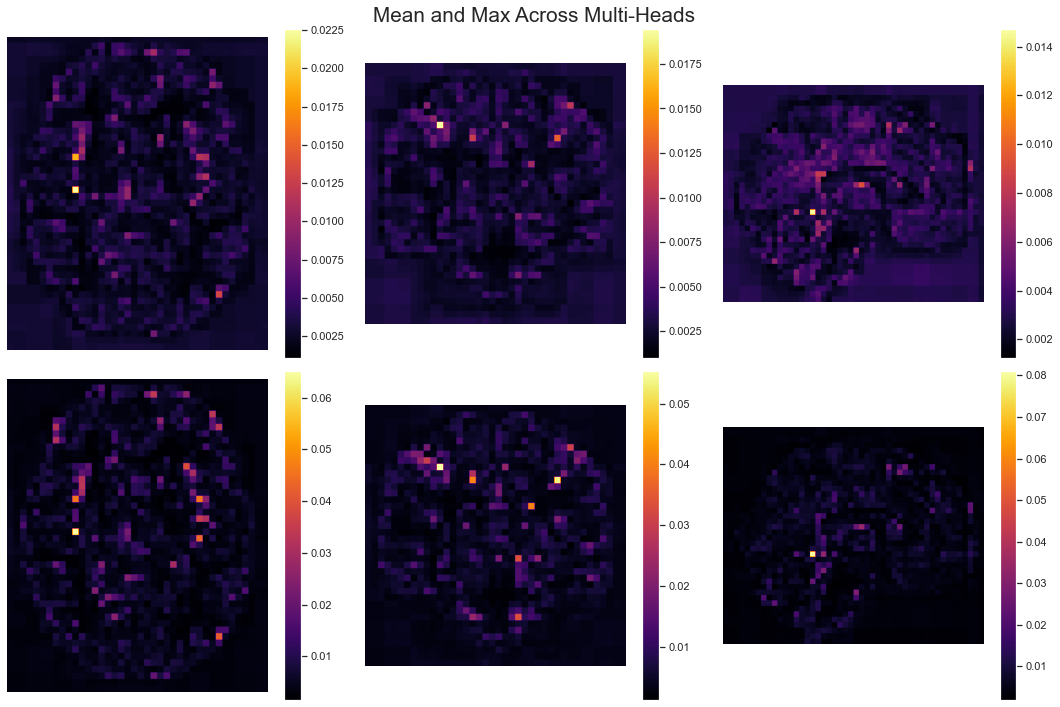

In [89]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=3, cmap='inferno')

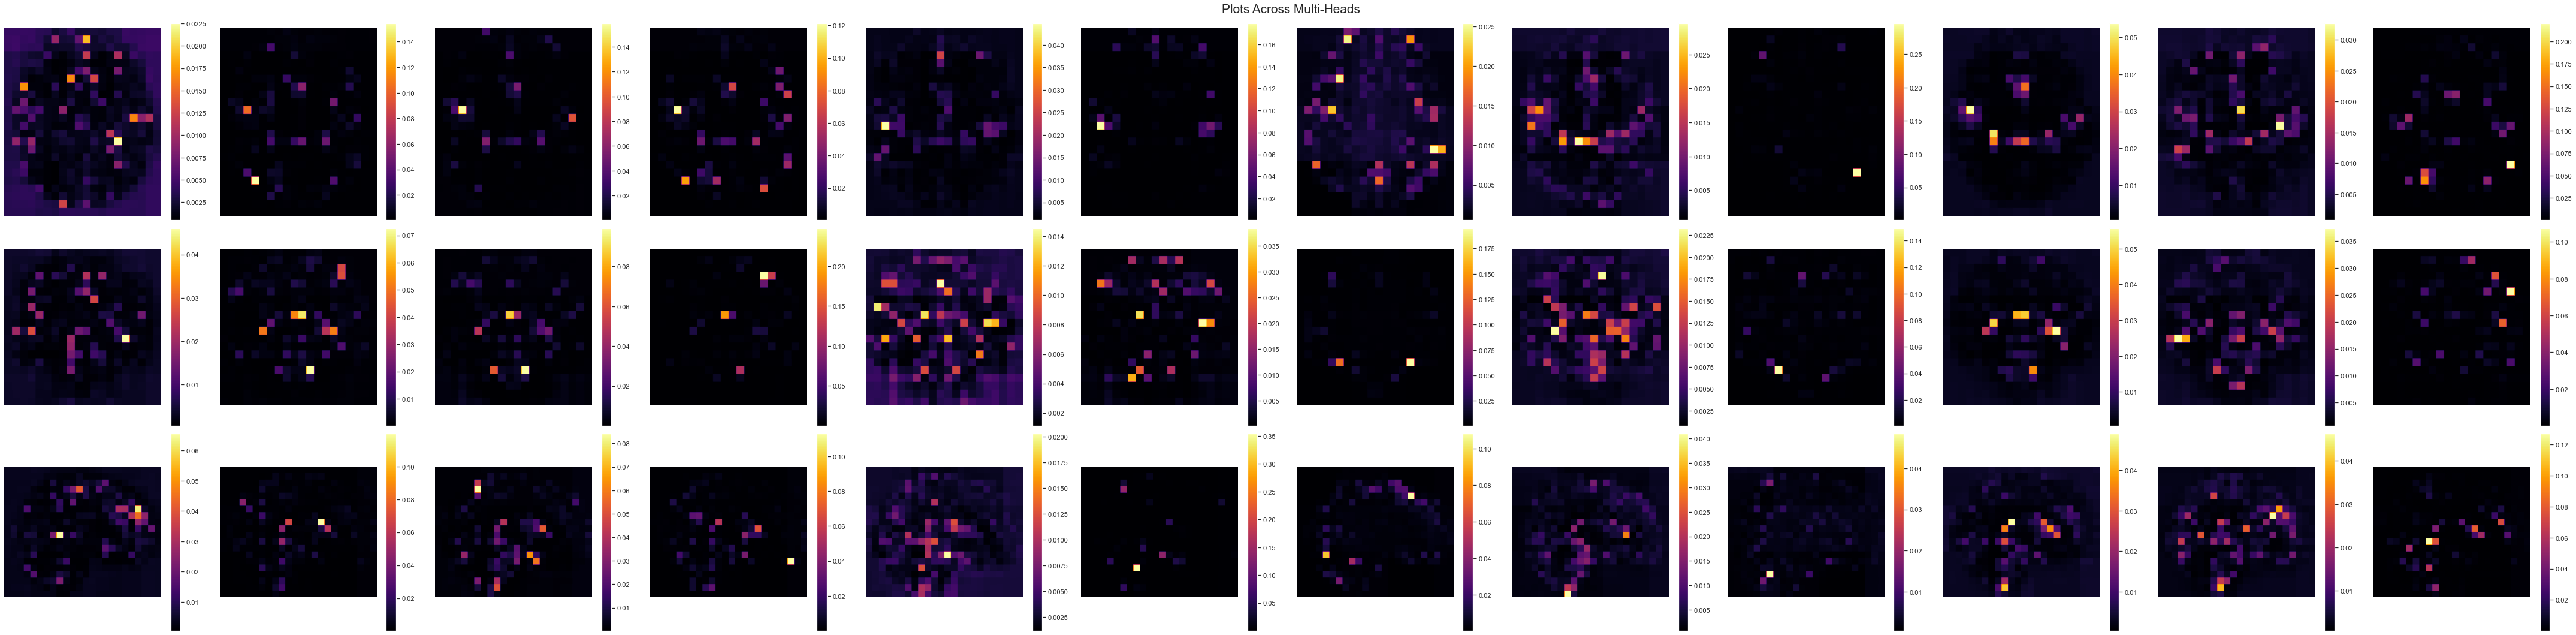

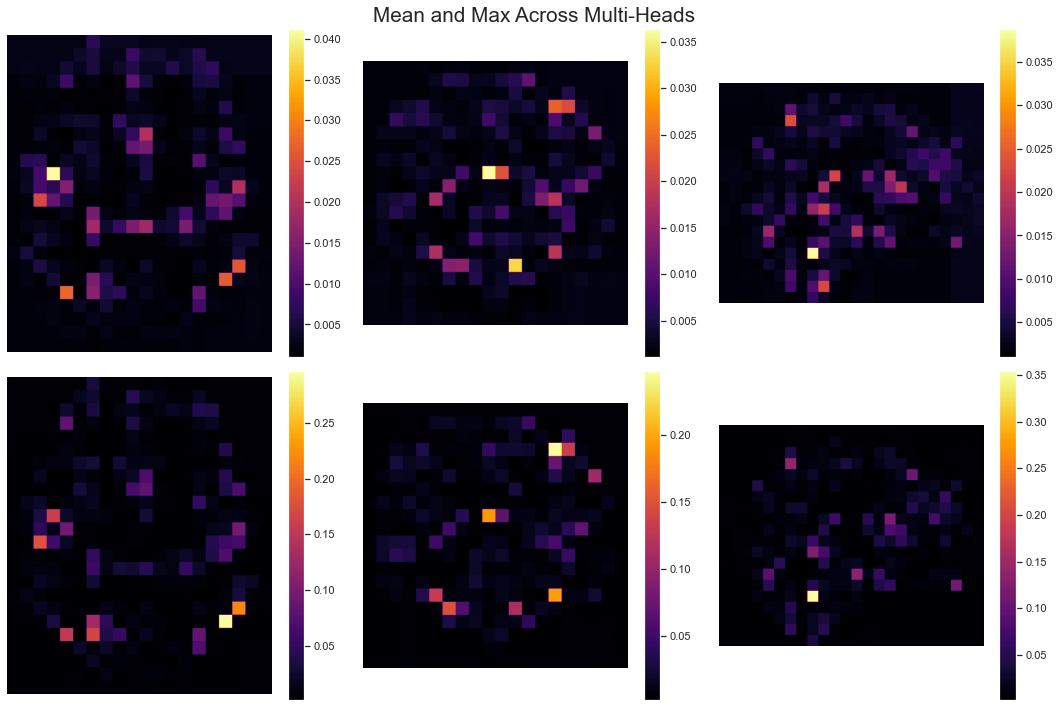

In [90]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=4, cmap='inferno')

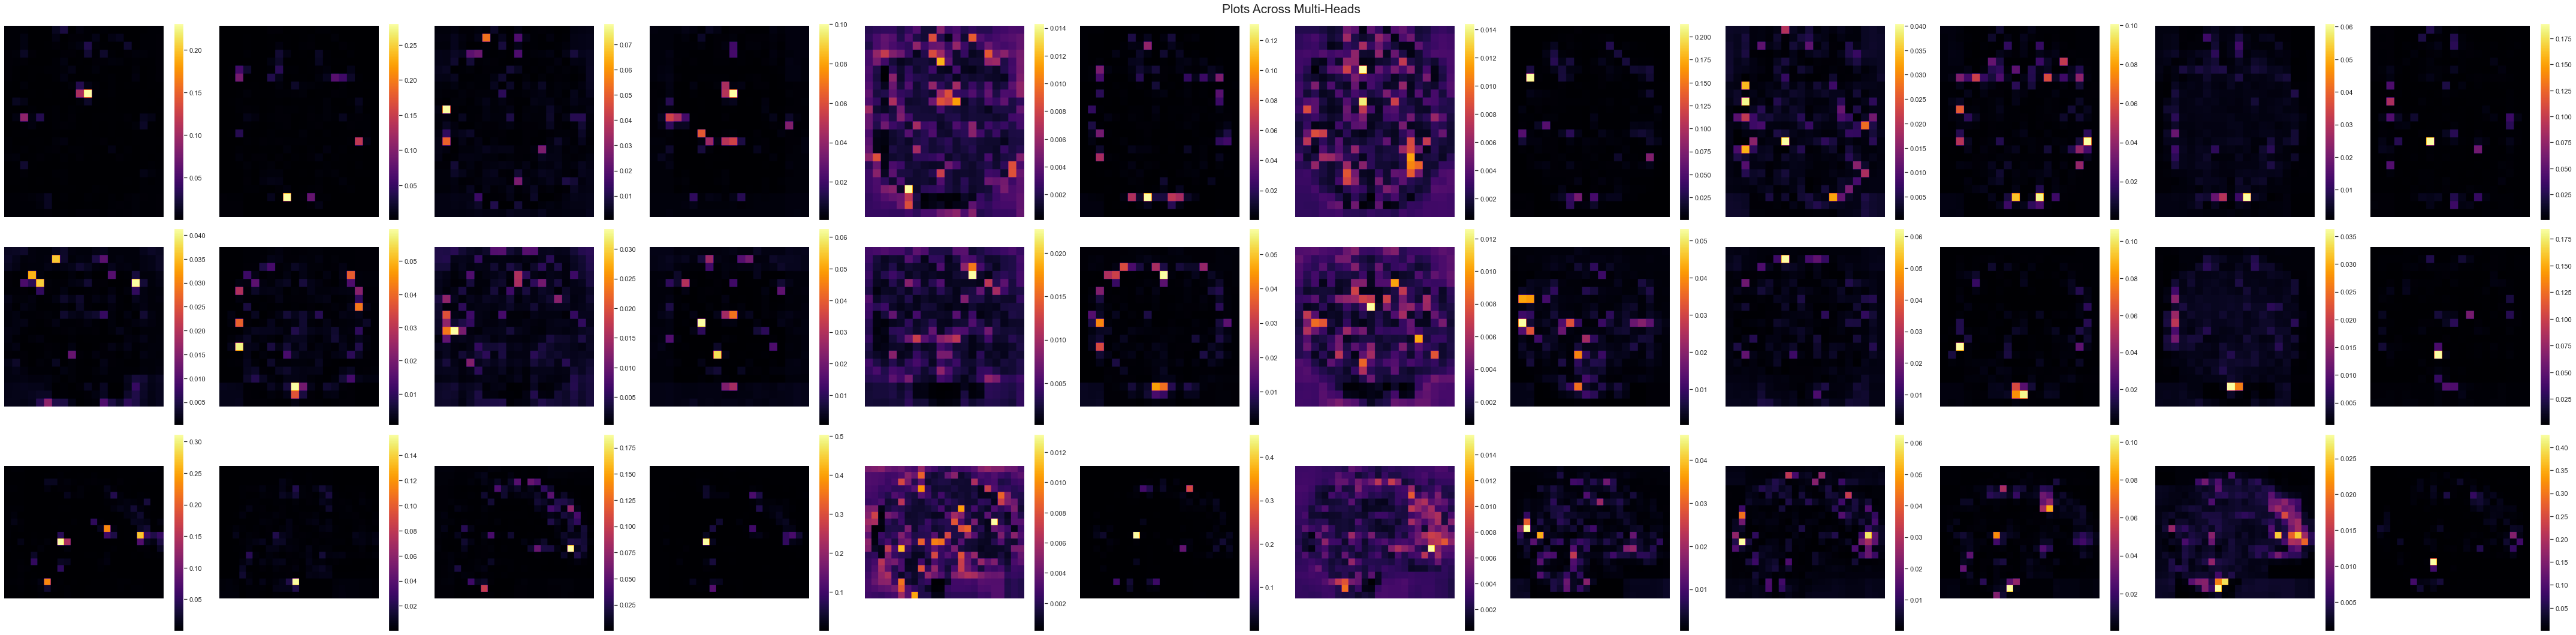

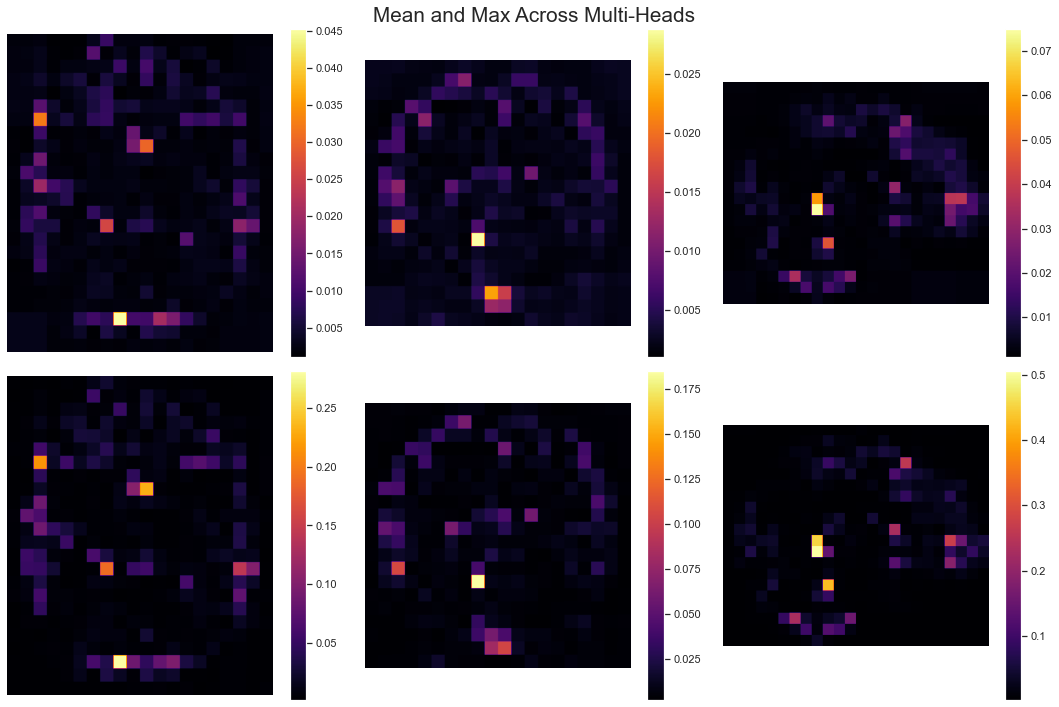

In [91]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=5, cmap='inferno')

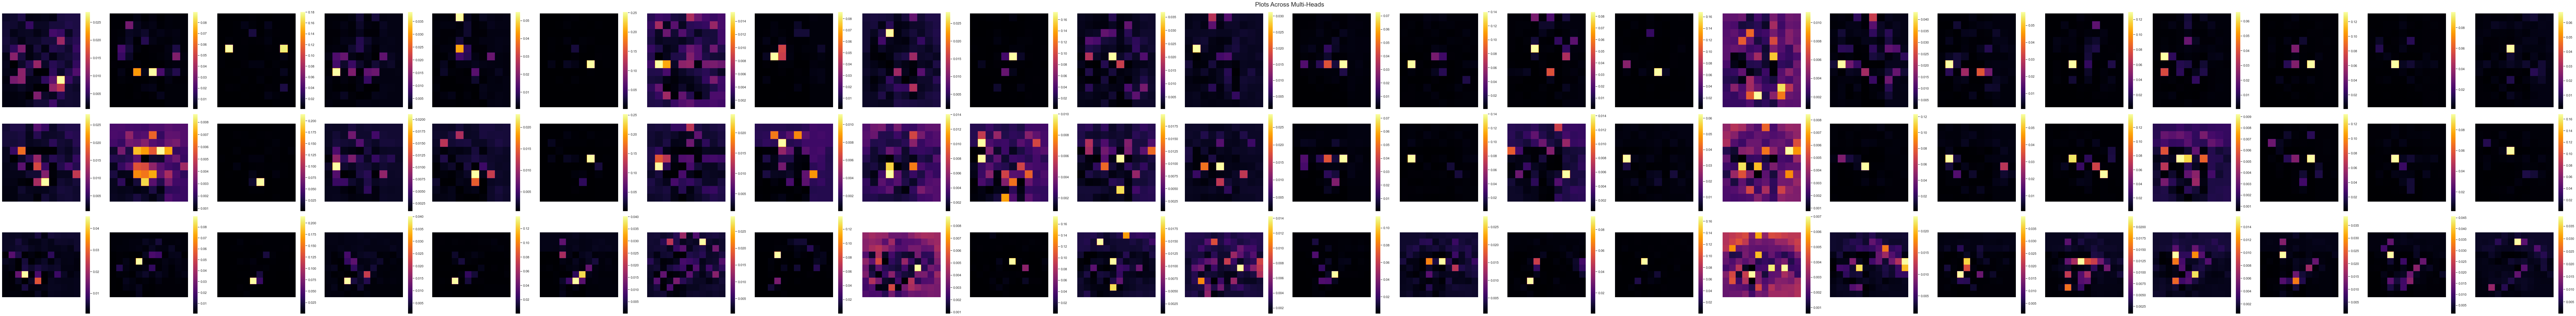

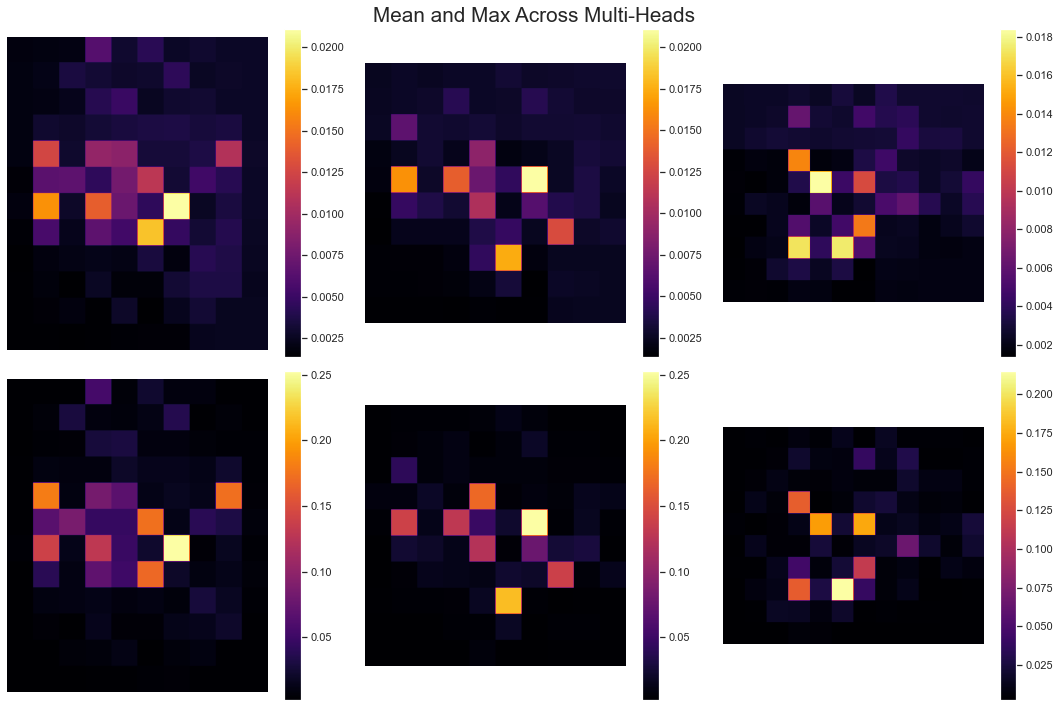

In [92]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=6, cmap='inferno')

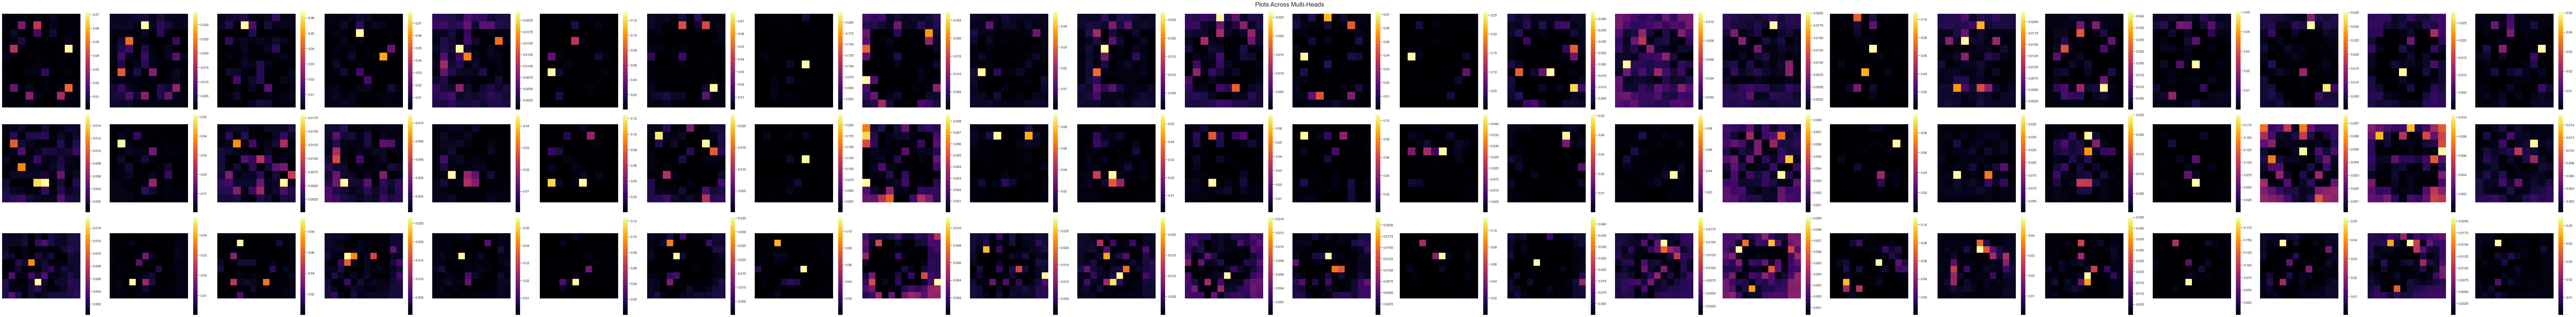

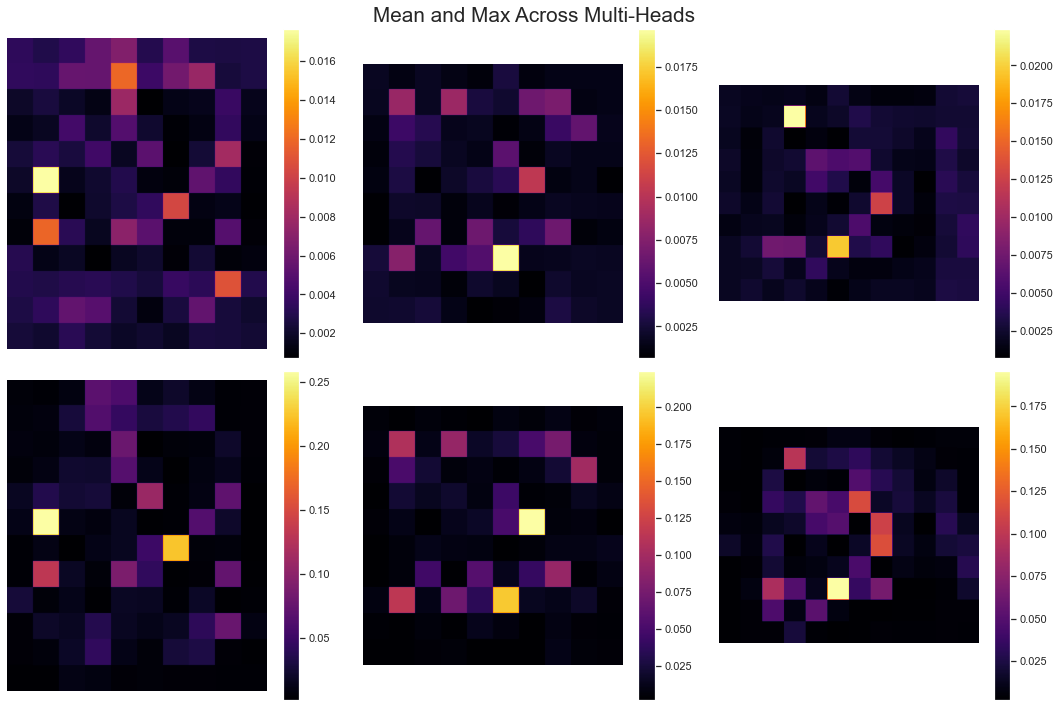

In [93]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=7, cmap='inferno')

In [94]:
for idx in range(len(outUpCropMeanS)):
    print(outUpCropMeanS[idx].shape)

torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])


# Let's look at some Attention Rollout

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import ndimage

In [14]:
outUpS = np.load('outUpS.npy', allow_pickle=True)

In [15]:
print(type(outUpS), outUpS.shape)

<class 'numpy.ndarray'> (8,)


In [16]:
print(type(outUpS[0]), outUpS[0].shape)

<class 'numpy.ndarray'> (3, 160, 192, 160)


In [5]:
def plotAttentionHead(outUpS, idx, cmap='viridis'):
    
    # CMAP ideas: viridis(default), inferno, bwr

    outUp = outUpS[idx]

    imgs = outUp.shape[0]

    fig, axs = plt.subplots(3, imgs, figsize=(imgs*5, 3*5))
    axs = axs.flatten()
    for i in range(imgs*3):
        if i < imgs:
            im = axs[i].imshow(ndimage.rotate(outUp[i,:,:,80], 90), cmap=cmap)
        elif i < 2*imgs:
            im = axs[i].imshow(ndimage.rotate(outUp[i-2*imgs,:,80,:], 90), cmap=cmap)
        else:
            im = axs[i].imshow(ndimage.rotate(outUp[i-3*imgs,80,:,:], 90), cmap=cmap)

        axs[i].grid()
        axs[i].axis('off');

        fig.colorbar(im, ax=axs[i])

    fig.tight_layout()
    st = fig.suptitle("Plots Across Multi-Heads", fontsize="xx-large")
    fig.subplots_adjust(top=0.95)


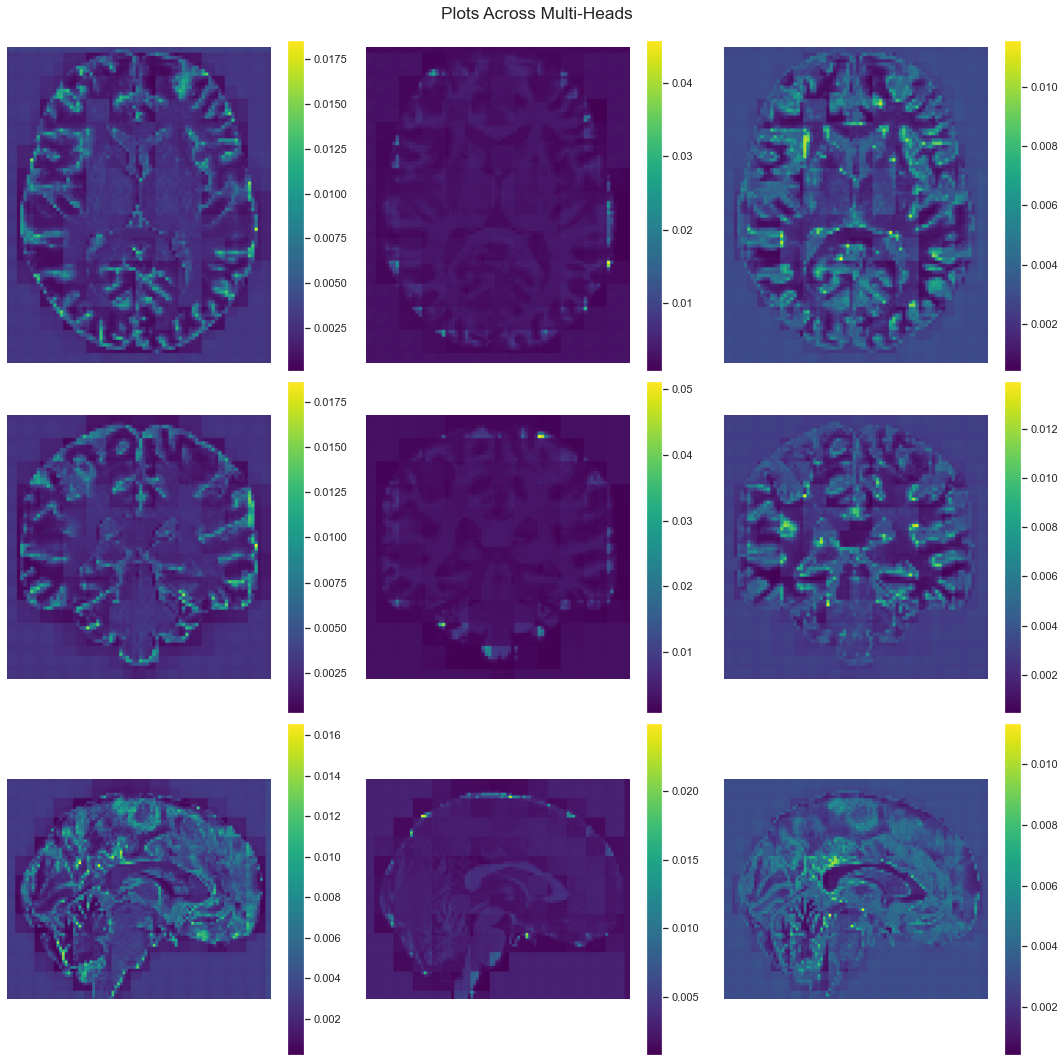

In [6]:
plotAttentionHead(outUpS, 1)

In [48]:
map1 = np.copy(outUpS[0])
map2 = np.copy(outUpS[1])

In [49]:
def plotAttentionHead_Overlay(outUpS, idx=None, cmap='viridis', vmin=None, vmax=None):
    
    # CMAP ideas: viridis(default), inferno, bwr

    if len(outUpS.shape) == 1:
        outUp = outUpS[idx]
    else:
        outUp = outUpS
    
    imgs = outUp.shape[0]

    fig, axs = plt.subplots(3, imgs, figsize=(imgs*5, 3*5))
    axs = axs.flatten()
    for i in range(imgs*3):
        if i < imgs:
            im = axs[i].imshow(ndimage.rotate(Xviz[:,:,80], 90), cmap='gray')
            im = axs[i].imshow(ndimage.rotate(outUp[i,:,:,80], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)
        elif i < 2*imgs:
            im = axs[i].imshow(ndimage.rotate(Xviz[:,80,:], 90), cmap='gray')
            im = axs[i].imshow(ndimage.rotate(outUp[i-2*imgs,:,80,:], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)
        else:
            im = axs[i].imshow(ndimage.rotate(Xviz[80,:,:], 90), cmap='gray')
            im = axs[i].imshow(ndimage.rotate(outUp[i-3*imgs,80,:,:], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)

        axs[i].grid()
        axs[i].axis('off');

        fig.colorbar(im, ax=axs[i])

    fig.tight_layout()
    st = fig.suptitle("Plots Across Multi-Heads", fontsize="xx-large")
    fig.subplots_adjust(top=0.95)

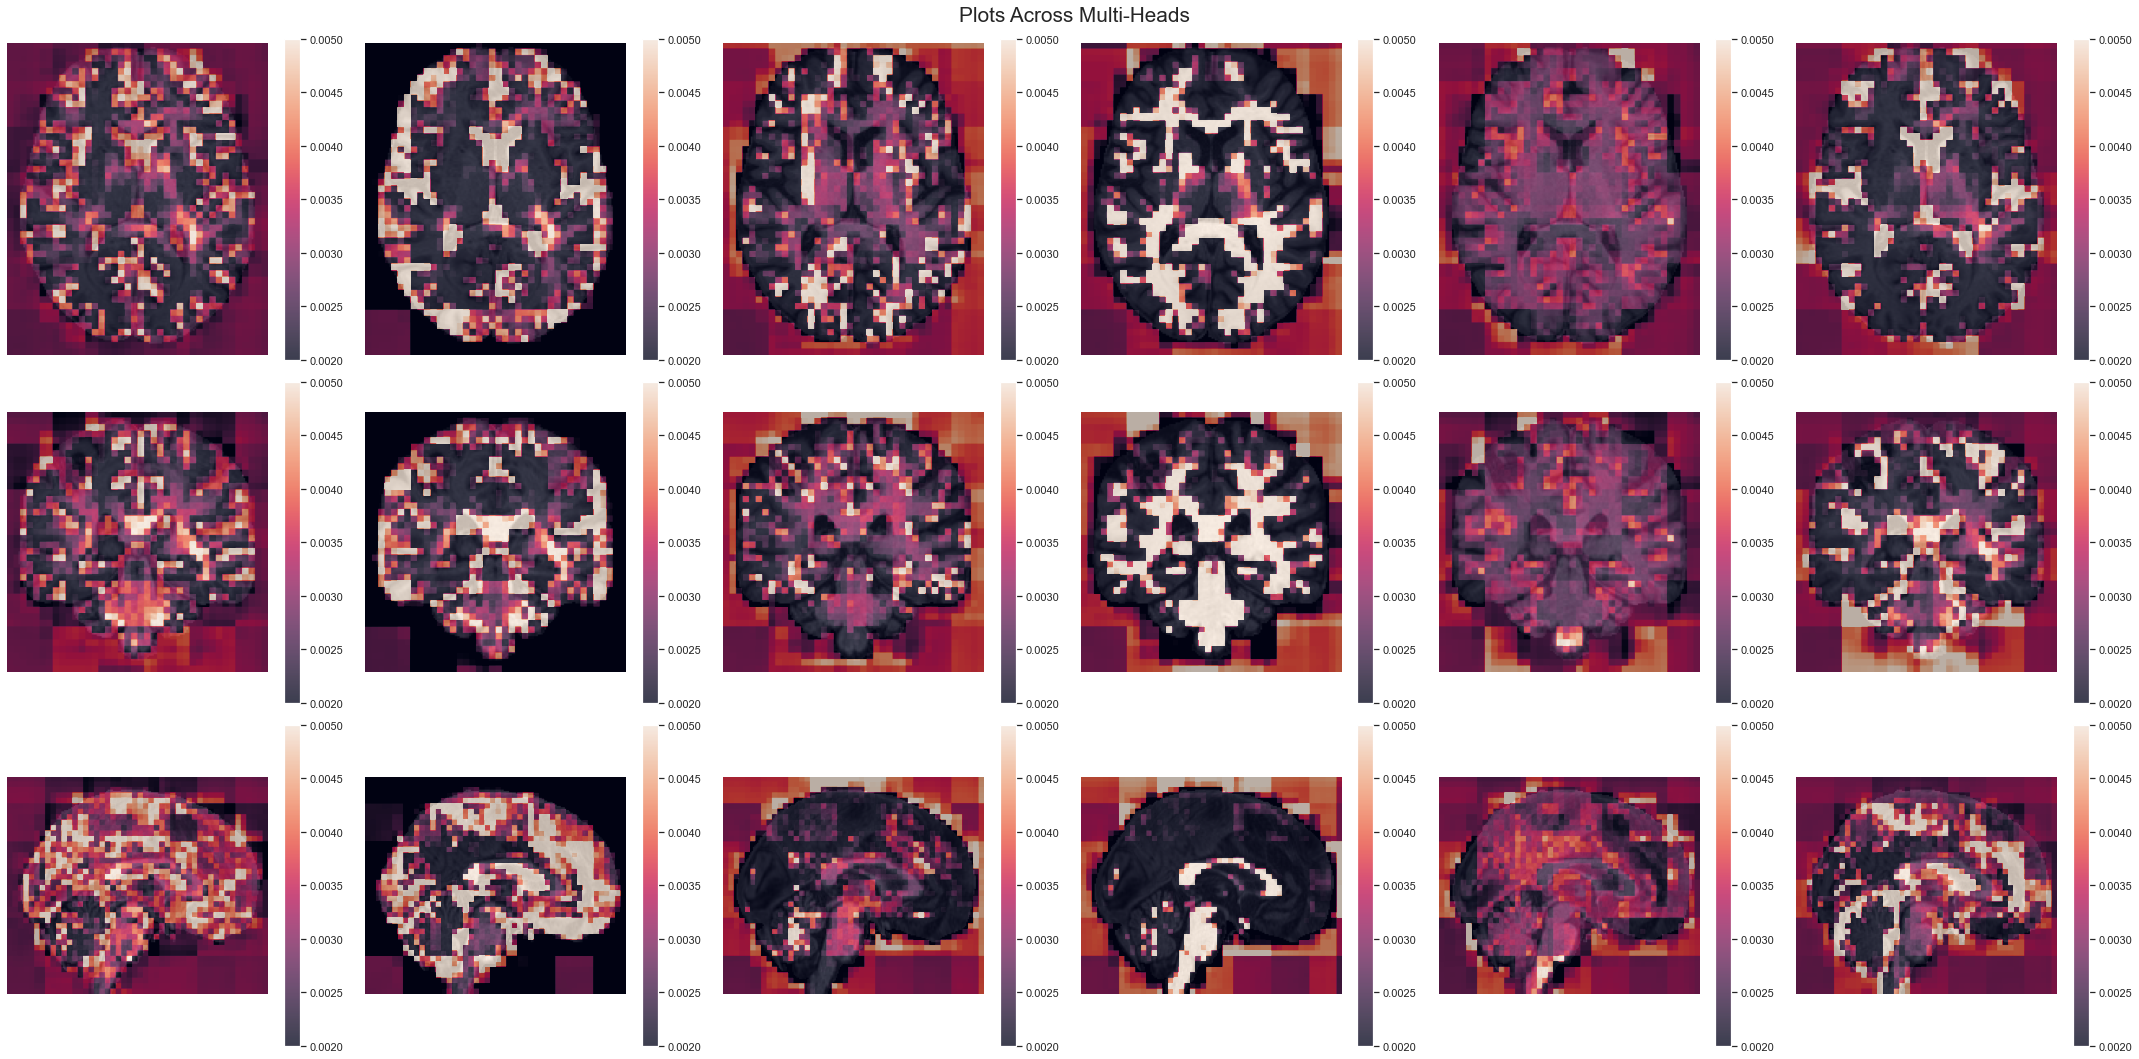

In [50]:
plotAttentionHead_Overlay(outUpS, 2, cmap=None, vmin=0.002, vmax=0.005)

In [51]:
# Note, in addition to rolling the images back into position, will need to eliminate
# padding ensure we get good alignment

In [52]:
# x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))

In [53]:
map1 = map1.mean(axis=0)
map2 = map2.mean(axis=0)

In [54]:
print(map1.shape, map2.shape)

(160, 192, 160) (160, 192, 160)


In [55]:
import torch.nn.functional as F

In [56]:
p = F.pad(input=torch.tensor(map1), pad=(0,32,0,0,0,32)) #, mode='constant', value=0)
p2 = F.pad(input=torch.tensor(map2), pad=(0,32,0,0,0,32)) #, mode='constant', value=0)
print(p.shape, p2.shape)

torch.Size([192, 192, 192]) torch.Size([192, 192, 192])


In [57]:
r = torch.matmul(p,p2)
r.shape

torch.Size([192, 192, 192])

In [58]:
r = r[:160, :, :160].contiguous()

In [59]:
r.shape

torch.Size([160, 192, 160])

(-0.5, 159.5, 191.5, -0.5)

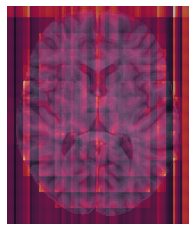

In [60]:
plt.imshow(ndimage.rotate(Xviz[:,:,80], 90), cmap='gray')
plt.imshow(ndimage.rotate(r[:,:,80], 90), alpha=0.75)
plt.grid()
plt.axis('off')

(-0.5, 159.5, 159.5, -0.5)

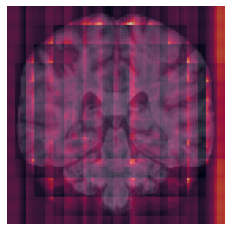

In [62]:
r = p @ p2
r = r[:160, :, :160].contiguous()
plt.imshow(ndimage.rotate(Xviz[:,80,:], 90), cmap='gray')
plt.imshow(ndimage.rotate(r[:,80,:], 90), alpha=0.75)
plt.grid()
plt.axis('off')

(-0.5, 191.5, 191.5, -0.5)

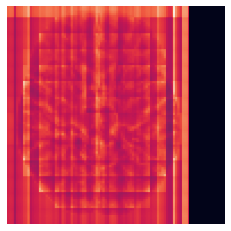

In [78]:
shape = (192,192,192)
identity_3d = np.zeros(shape)
idx = np.arange(shape[0])
identity_3d[idx, idx, :] = 1


In [105]:
identity_3d.shape

(192, 192, 192)

In [80]:
a = np.random.randn(192,192,192)

In [81]:
b = a @ identity_3d

In [85]:
(a - b).sum()

18679.44995992819

In [92]:
from fsl.data.image import Image
img = Image(identity_3d)
img.save('identity_3d.nii.gz')

In [28]:
for idx in range(len(outUpS)):
    vol = np.copy(outUpS[idx])
    vol = vol.mean(axis=0)
    vol = torch.Tensor(vol)
    if idx == 0:
        r = vol
    else:
        if idx % 2 == 1:
            r = torch.matmul(r,torch.transpose(vol,1,2))
        else:
            r = torch.matmul(r,vol)
    print(idx)

0
1
2
3
4
5
6
7


(-0.5, 191.5, 191.5, -0.5)

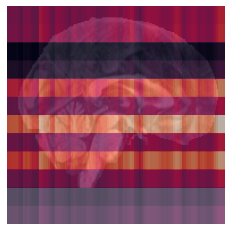

In [24]:
plt.imshow(ndimage.rotate(Xviz[80,:,:], 90), cmap='gray')
plt.imshow(ndimage.rotate(r[80,:,:], 90), alpha=0.75)
plt.grid()
plt.axis('off')

In [31]:
for idx in range(len(outUpS)):
    vol = np.copy(outUpS[idx])
    vol = vol.mean(axis=0)
    vol = torch.Tensor(vol)
    vol = vol.transpose(1,2)
    vol = F.pad(input=vol, pad=(0,0,0,32,0,32)) #, mode='constant', value=0)
    if idx == 0:
        r = vol
    else:
        r = torch.matmul(r,vol)
    print(idx)
    
r = r[:160, :160, :]

0
1
2
3
4
5
6
7


In [32]:
r = r.transpose(1,2)
r.shape

torch.Size([160, 192, 160])

(-0.5, 191.5, 159.5, -0.5)

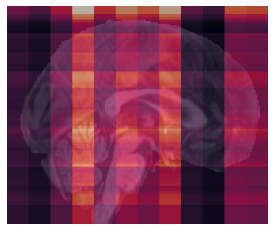

In [36]:
plt.imshow(ndimage.rotate(Xviz[80,:,:], 90), cmap='gray')
plt.imshow(ndimage.rotate(r[80,:,:], 90), alpha=0.75)
plt.grid()
plt.axis('off')

In [37]:
vol = np.copy(outUpS[idx])
vol = vol.mean(axis=0)
vol = torch.Tensor(vol)
vol = vol.transpose(1,2)
vol = F.pad(input=vol, pad=(0,0,0,32,0,32)) #, mode='constant', value=0)

In [38]:
F.pad(input=vol, pad=(0,0,0,32,0,32)).shape

torch.Size([224, 224, 192])

In [39]:
del outUpCropMeanS

NameError: name 'outUpCropMeanS' is not defined

In [40]:
for idx in range(len(outUpS)):
    vol = np.copy(outUpS[idx])
    vol = vol.mean(axis=0)
    vol = F.pad(input=torch.tensor(vol), pad=(0,32,0,0,0,32)) #, mode='constant', value=0)
    if idx == 0:
        r = vol
    else:
        r = torch.matmul(r,vol)
    print(idx)

0
1
2
3
4
5
6
7


In [41]:
r = r[:160, :, :160]

(-0.5, 159.5, 159.5, -0.5)

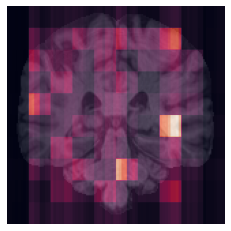

In [44]:
plt.imshow(ndimage.rotate(Xviz[:,80,:], 90), cmap='gray')
plt.imshow(ndimage.rotate(r[:,80,:], 90), alpha=0.75)
plt.grid()
plt.axis('off')

In [155]:
for idx in range(len(outUpS)):
    vol = np.copy(outUpS[idx])
    vol = vol.mean(axis=0)
    vol = F.pad(input=torch.tensor(vol), pad=(0,32,0,0,0,32)) #, mode='constant', value=0)
    I = torch.eye(vol.size(-1))
    vol = (vol + 1.0*I)/2
#     vol = vol / vol.sum(dim=-1)
    if idx == 0:
        r = vol
    else:
        r = torch.matmul(r,vol)
    print(idx)

0
1
2
3
4
5
6
7


In [156]:
r = r[:160, :, :160]

(-0.5, 159.5, 191.5, -0.5)

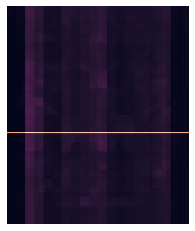

In [158]:
plt.imshow(ndimage.rotate(r[:,:,80], 90))
plt.grid()
plt.axis('off')

In [142]:
for idx in range(len(outUpS)):
    vol = np.copy(outUpS[idx])
    vol = vol.mean(axis=0)
#     vol = F.pad(input=torch.tensor(vol), pad=(0,32,0,0,0,32)) #, mode='constant', value=0)
    vol = (vol + 1.0*identity_3d)/2
    vol = vol / vol.sum(dim=-1)
    if idx == 0:
        r = vol
    else:
        r = torch.matmul(r,vol)
    print(idx)

ValueError: operands could not be broadcast together with shapes (160,192,160) (192,192,192) 

In [138]:
r = r[:160, :, :160]

(-0.5, 159.5, 191.5, -0.5)

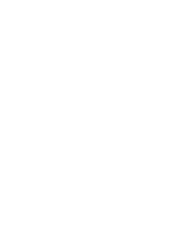

In [139]:
plt.imshow(ndimage.rotate(r[:,:,90], 90))
plt.grid()
plt.axis('off')

In [141]:
vol.sum(dim=-1)

tensor([[532.9152,   1.1394,   1.1394,  ...,      nan,      nan,      nan],
        [  1.1394, 532.9152,   1.1394,  ...,      nan,      nan,      nan],
        [  1.1394,   1.1394, 532.9152,  ...,      nan,      nan,      nan],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,      inf,      nan,      nan],
        [  0.0000,   0.0000,   0.0000,  ...,      nan,      inf,      nan],
        [  0.0000,   0.0000,   0.0000,  ...,      nan,      nan,      inf]],
       dtype=torch.float64)

In [146]:
a = torch.randn(160,192,160)
b = torch.randn(160,192,160)

In [153]:
torch.matmul(a,b.transpose(1,2)).shape

torch.Size([160, 192, 192])

In [154]:
b.transpose(1,2).shape

torch.Size([160, 160, 192])

In [114]:
I = torch.eye(p.size(-1))

In [115]:
I.shape

torch.Size([192, 192])

In [118]:
q = (p + 1.0*I)/2

In [121]:
q = q / q.sum(dim=-1)

In [122]:
q.shape

torch.Size([192, 192, 192])